In [74]:
### IMPORTS ###

%matplotlib inline
# Importing standard Qiskit libraries and configuring account
from qiskit import QuantumCircuit, execute, Aer, IBMQ
from qiskit.compiler import transpile, assemble
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from qiskit.providers.ibmq import least_busy
from qiskit.quantum_info import Statevector
import numpy as np
pi = np.pi

# Loading your IBM Q account(s)
provider = IBMQ.load_account()

/opt/conda/lib/python3.7/site-packages/qiskit/providers/ibmq/ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '
ibmqfactory.load_account:WARNING:2020-10-12 23:17:38,435: Credentials are already in use. The existing account in the session will be replaced.


In [75]:
### BASIC INPUT INFORMATION ###

## Tagged State ##
# Enter a bit string for the tagged state
wstate = "1101"

## Number of Qubits ##
# Current suport for n = 3,4,5
n = 4

## Number of Iterations ##
R = 1

## Set up Quantum Circuit ##
gc = QuantumCircuit(n)

In [76]:
### INITIAL STATE OF THE CIRCUIT ###

def initial_s(qc, n):
    for q in range(n):
        qc.h(q)
    return qc

In [77]:
### GROVER ORACLE ###
def Gate(Uf, n, wstate, label="$U_f$"):
    
    ## Quantum Circuit Application of Uf ##
    qc = QuantumCircuit(n)
    
    ## 1st Set of X Gates for Tagged State ##
    for i in range(len(wstate)):  ## add error for incorect bit strings?
        if wstate[i] == '0':
            qc.x(i) 
            
    ## Oracle for 3-Qubit Case ##
    if n == 3: 
        # Control z-gate
        qc.cu1(pi/2, 0, 2)
        qc.cx(0, 1)
        qc.cu1(-pi/2, 1, 2)
        qc.cx(0, 1)
        qc.cu1(pi/2, 1, 2)
        
    ## Oracle for 4-Qubit Case ##
    elif n == 4: 
        # Control z-gate
        qc.cu1(pi/4, 0, 3)
        qc.cx(0, 1)
        qc.cu1(-pi/4, 1, 3)
        qc.cx(0, 1)
        qc.cu1(pi/4, 1, 3)
        qc.cx(1,2)
        qc.cu1(-pi/4, 2, 3)
        qc.cx(0, 2)
        qc.cu1(pi/4, 2, 3)
        qc.cx(1, 2)
        qc.cu1(-pi/4, 2, 3)
        qc.cx(0, 2)
        qc.cu1(pi/4, 2, 3)

    ## Oracle for 5-Qubit Case ##
    elif n == 5:
        # Control z-gate
        qc.cu1(pi/8, 0, 4)
        qc.cx(0, 1)
        qc.cu1(-pi/8, 1, 4)
        qc.cx(0, 1)
        qc.cu1(pi/8, 1, 4)
        qc.cx(1, 2)
        qc.cu1(-pi/8, 2, 4)
        qc.cx(0, 2)
        qc.cu1(pi/8, 2, 4)
        qc.cx(1, 2)
        qc.cu1(-pi/8, 2, 4)
        qc.cx(0, 2)
        qc.cu1(pi/8, 2, 4)
        qc.cx(0, 3)
        qc.cu1(-pi/8, 3, 4)
        qc.cx(2, 3)
        qc.cu1(pi/8, 3, 4)
        qc.cx(1, 3)
        qc.cu1(-pi/8, 3, 4)
        qc.cx(2, 3)
        qc.cu1(pi/8, 3, 4)
        qc.cx(0, 3)
        qc.cu1(-pi/8, 3, 4)
        qc.cx(2, 3)
        qc.cu1(pi/8, 3, 4)
        qc.cx(1, 3)
        qc.cu1(-pi/8, 3, 4)
        qc.cx(2, 3)
        qc.cu1(pi/8, 3, 4)
        
    ## 2nd Set of X Gates for Tagged State ##
    for i in range(len(wstate)):  ## add error for incorect bit strings?
        if wstate[i] == '0':
            qc.x(i) 

    ## Return gate and proper label ##
    #Uf = qc.to_gate()
    #Uf.name = "$U_f$"
    return Uf

In [78]:
### GROVER DIFFUSION ###
def Gate(Us, n, label="$U_s$"):
    ## Quantum Circuit For Application of Us ##
    qc = QuantumCircuit(n)
    
    # First set of Hadamard Gates 
    for i in range(n):
        qc.h(i)
    # First set of X Gates 
    for i in range(n):
        qc.x(i)
    # Multi-controlled-Z gate
    qc.h(n-1)
    qc.mct(list(range(n-1)), n-1)  # multi-controlled-toffoli
    qc.h(n-1)
    # Second set of X Gates 
    for i in range(n):
        qc.x(i)
    # Second set of Hadamard Gates 
    for i in range(n):
        qc.h(i)
        
    # Return gate and proper label
    #Us = qc.to_gate()
    #Us.name = "$U_s$"
    return Us   

In [79]:
### CREATE THE GROVER'S ALGORITHM CIRCUIT ###

## Initialize the state s ##
gc = initial_s(gc, n)

## 3-Quit Case ##
if n == 3:
    # Repeat for Specified Number of Iterations
    for i in range(R):
        for i in range(n):
            gc.barrier(i)
        gc.append(Uf(n, wstate), [0,1,2])
        gc.append(Us(n), [0,1,2])
        i = i + 1

## 4-Qubit Case ##
elif n == 4:
    # Repeat for Specified Number of Iterations
    for i in range(R):
        for i in range(n):
            gc.barrier(i)
        gc.append(Uf(n, wstate), [0,1,2,3])
        gc.append(Us(n), [0,1,2,3])
        i = i + 1
    
## 5-Qubit Case ##
elif n == 5:
    # Repeat for Specified Number of Iterations
     for i in range(R):
        for i in range(n):
            gc.barrier(i)
        gc.append(Uf(n, wstate), [0,1,2,3,4])
        gc.append(Us(n), [0,1,2,3,4])
        i = i + 1

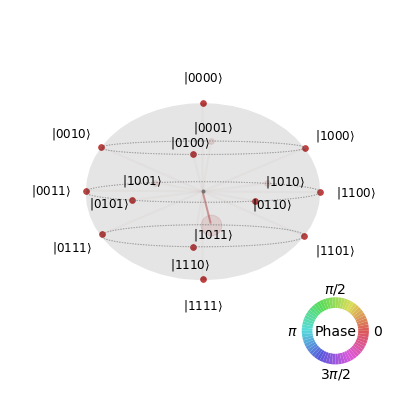

In [80]:
## Plot the Circuit on the Q-Sphere ##
statevector = Statevector.from_instruction(gc)
plot_state_qsphere(statevector)

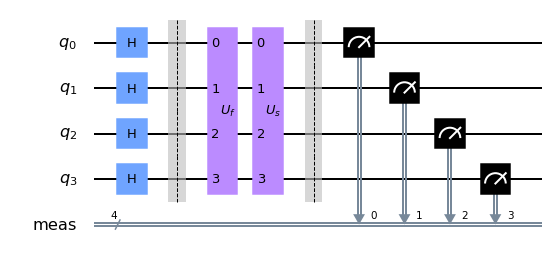

In [81]:
## Measure Each Qubit ##
gc.measure_all()
## Draw the Circuit Representation ##
gc.draw()

#### Add feature for drawing details of custom gates? ###
## Draw Examples of Each Defined Gate For Reference ##
#oracle_qc = QuantumCircuit(n)
#diffuser_qc = QuantumCircuit(n)
#oracle_qc.Uf ...

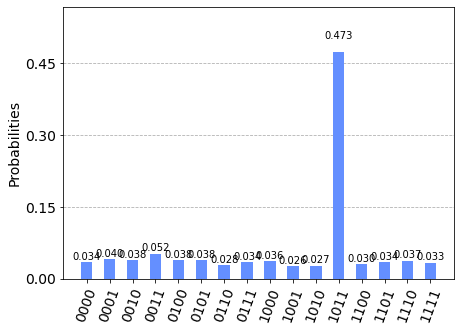

In [82]:
### SIMULATE THE GROVER"S ALGORITHM CIRCUIT ###

## Set up Simulator and Record Results ##
simulator = Aer.get_backend('qasm_simulator')
shots = 1024
results = execute(gc, backend = simulator, shots=shots).result()
counts = results.get_counts()

## Plot the Counts from the Simulated Results ##
plot_histogram(counts)